We are interested in generating meaningful interpolations and extrapolations based on the learned letterforms. therefore we start by evaluating the model's ability to interpolate between different variations in the same writing system such as weight (thickness), size, rotation, slant and style (font family). we then explore the extrapolation capabilities between letterforms of different writing systems.

We compare models with different latent dimensions and other hyperparameters. we also compare the results of the models trained on different datasets with different levels of augmentation.

In [18]:
import torch
from torch.autograd import Variable
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
MODELS_DIR = './results/experiment 3/models/'

%matplotlib inline
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model

In [12]:
from src.capsnet import CapsNet, ReconstructionNet, CapsNetWithReconstruction, MarginLoss

routing_iterations = 3
n_classes = 13
with_reconstruction = True

model = CapsNet(routing_iterations, n_classes)

if with_reconstruction:
    reconstruction_model = ReconstructionNet(16, n_classes)
    model = CapsNetWithReconstruction(model, reconstruction_model)

# Load trained model
MODEL_PATH = 'pretrained_models/100_model_dict_3routing_reconstructionTrue.pth'
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(device)))

<All keys matched successfully>

# Helper functions

In [9]:
# (1x28x28 tensor input)
def get_digit_caps(model, image):
    input_ = Variable(image.unsqueeze(0), volatile=True)
    digit_caps, probs = model.capsnet(input_)
    return digit_caps

# takes digit_caps output and target label
def get_reconstruction(model, digit_caps, label):
    target = Variable(torch.LongTensor([label]), volatile=True)
    reconstruction = model.reconstruction_net(digit_caps, target)
    return reconstruction.data.cpu().numpy()[0].reshape(28, 28)

# create reconstructions with perturbed digit capsule
def dimension_perturbation_reconstructions(model, digit_caps, label, dimension, dim_values):
    reconstructions = []
    for dim_value in dim_values:
        digit_caps_perturbed = digit_caps.clone()
        digit_caps_perturbed[0, label, dimension] = dim_value
        reconstruction = get_reconstruction(model, digit_caps_perturbed, label)
        reconstructions.append(reconstruction)
    return reconstructions

# Visualizations

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

## Sample reconstructions

In [55]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from src.datasets import GraphemesDataset

img_transform = transforms.Compose([
    transforms.ToTensor()
])

letter = "aleph"

ds_type = "rotation"
root_dir = f"datasets/{ds_type}_dataset"


dataset = GraphemesDataset(root_dir, test_size=0, by_letter=letter, transform=img_transform)

/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_6928/3938252321.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_ = Variable(image.unsqueeze(0), volatile=True)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_6928/3938252321.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target = Variable(torch.LongTensor([label]), volatile=True)


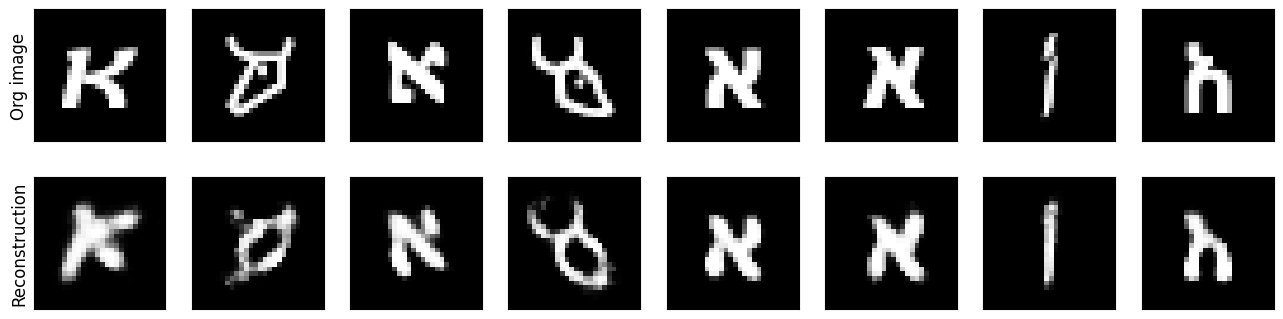

In [88]:
# Get reconstructions
images = []
labels = []
reconstructions = []
# sample 8 random images from the dataset
idx = np.random.randint(0, len(dataset), size=8)
for i in idx:
    image_tensor, label = dataset[i]
    digit_caps = get_digit_caps(model, image_tensor)
    reconstruction = get_reconstruction(model, digit_caps, label)
    images.append(image_tensor)
    labels.append(label)
    reconstructions.append(reconstruction)

# Plot reconstructions
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
axs[0, 0].set_ylabel('Org image', size='large')
axs[1, 0].set_ylabel('Reconstruction', size='large')
for i in range(8):
    axs[0, i].imshow(images[i].numpy()[0], cmap='gray')
    axs[1, i].imshow(reconstructions[i], cmap='gray')
    axs[0, i].set_yticks([])
    axs[0, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[1, i].set_xticks([])

## What the individual dimensions of a capsule represent

We can visualize what an individual dimension of a capsule represents by perturbing values of each dimension (sec. 5.1. of the paper, figure 4).
Each row shows the reconstruction when one of the 16 dimensions in the DigitCaps representation is tweaked by intervals of 0.05 in the range [−0.25, 0.25].

/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_6928/3938252321.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_ = Variable(image.unsqueeze(0), volatile=True)
/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_6928/3938252321.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  target = Variable(torch.LongTensor([label]), volatile=True)


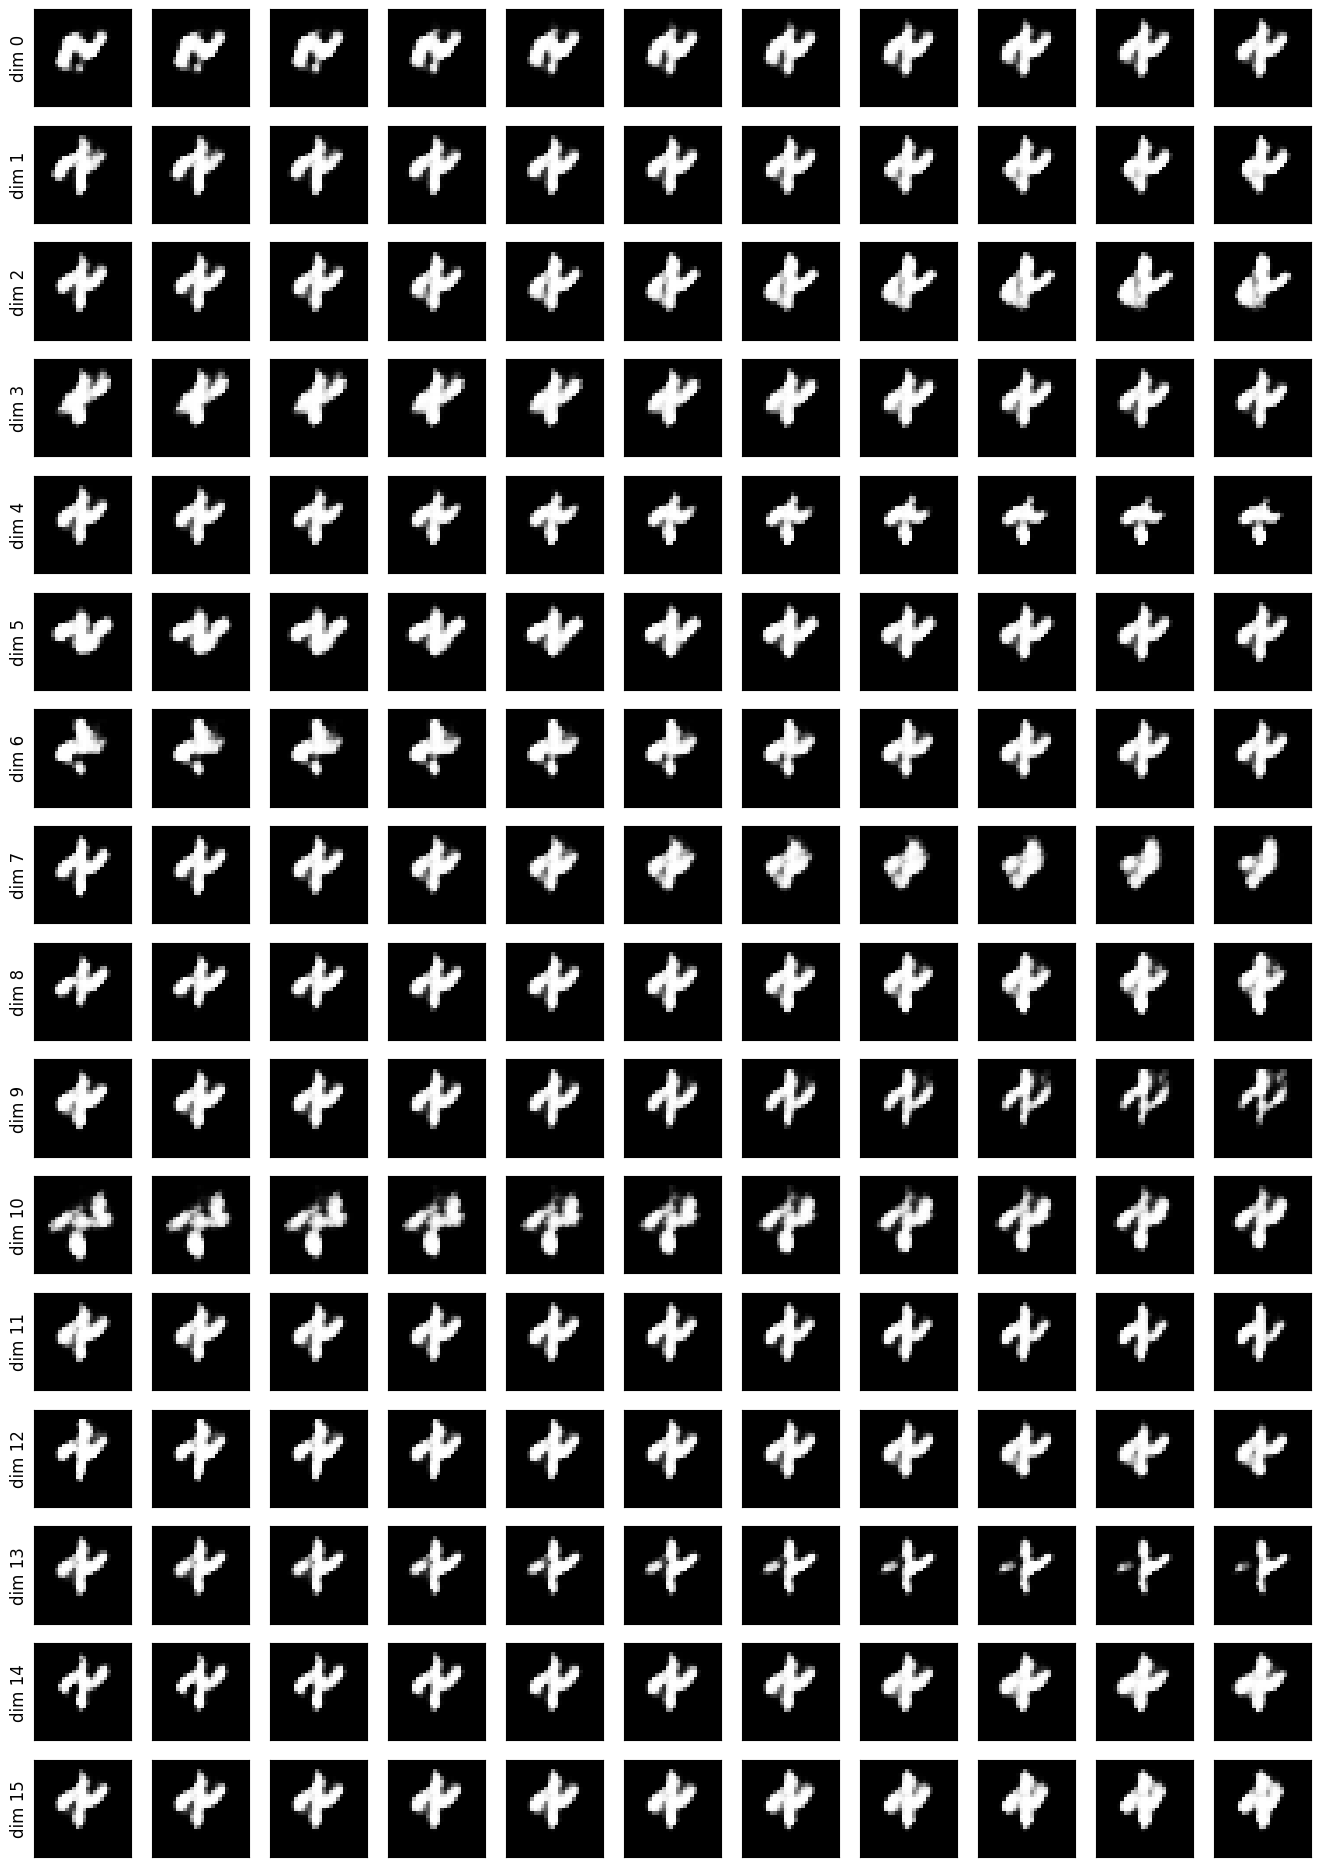

In [32]:
digit, label = images[2], labels[2]
perturbed_reconstructions = []
perturbation_values = [0.05*i for i in range(-5, 6)]
digit_caps = get_digit_caps(model, digit)
for dimension in range(16):
    perturbed_reconstructions.append(
        dimension_perturbation_reconstructions(model, digit_caps, label,
                                               dimension, perturbation_values)
    )

fig, axs = plt.subplots(16, 11, figsize=(11*1.5, 16*1.5))
for i in range(16):
    axs[i, 0].set_ylabel('dim {}'.format(i), size='large')
    for j in range(11):
        axs[i, j].imshow(perturbed_reconstructions[i][j], cmap='gray')
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])

# Load base dataset
this is a dataset where all letters are centered, not rotated and with a fixed size.

In [56]:
from torch.utils.data import DataLoader
from torchvision import transforms
from src.datasets import GraphemesDataset
data_dir = "datasets/base_dataset/"

img_transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = GraphemesDataset(data_dir, test_size=0, by_letter=letter, transform=img_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


# Explore the latent representations of the base dataset

In [68]:
# convert all images to their latent representation using the encoder

# images will be a list of all images in the dataset in the same order as the labels and latent_representations lists
# you should add all images from all batches to the list and make sure to
# convert it to PIL images of 28 x 28

from PIL import Image        


def get_latent_representation(model, dataloader, device):
    images = []
    reconstructions = []
    latent_representations = []
    labels = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            for tensor in x:
                # Remove the batch dimension and convert the tensor to a numpy array
                image_np = tensor.squeeze().cpu().numpy()
                # Convert numpy array to PIL image
                pil_image = Image.fromarray((image_np * 255).astype('uint8'), mode='L')
                images.append(pil_image)

            x = x.to(device)
            digit_caps, probs = model.capsnet(x)
            recon = model.reconstruction_net(digit_caps, y)
            latent_representations.append(digit_caps)
            reconstructions.append(recon.data.view(-1, 1, 28, 28))
            labels.append(y)

    latent_representations = torch.cat(latent_representations).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    reconstructions = torch.cat(reconstructions).cpu().numpy()

    pil_reconstructions = []
    for img_np in reconstructions:
        img_np = img_np.squeeze() * 255
        pil_img = Image.fromarray(img_np.astype('uint8'), mode='L')
        pil_reconstructions.append(pil_img)

    return images, labels, latent_representations, pil_reconstructions

images, y, z, reconstructions = get_latent_representation(model, dataloader, device)

/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)


If the latent dimension is bigger than 2, we can't visualize it.
We use tSNE to reduce the dimension to 2.

In [49]:
from sklearn.manifold import TSNE

if z.shape[1] > 2:
    tsne = TSNE(n_components=2, perplexity=15) 
    z_tsne = tsne.fit_transform(z.reshape(z.shape[0], -1))
    z = z_tsne

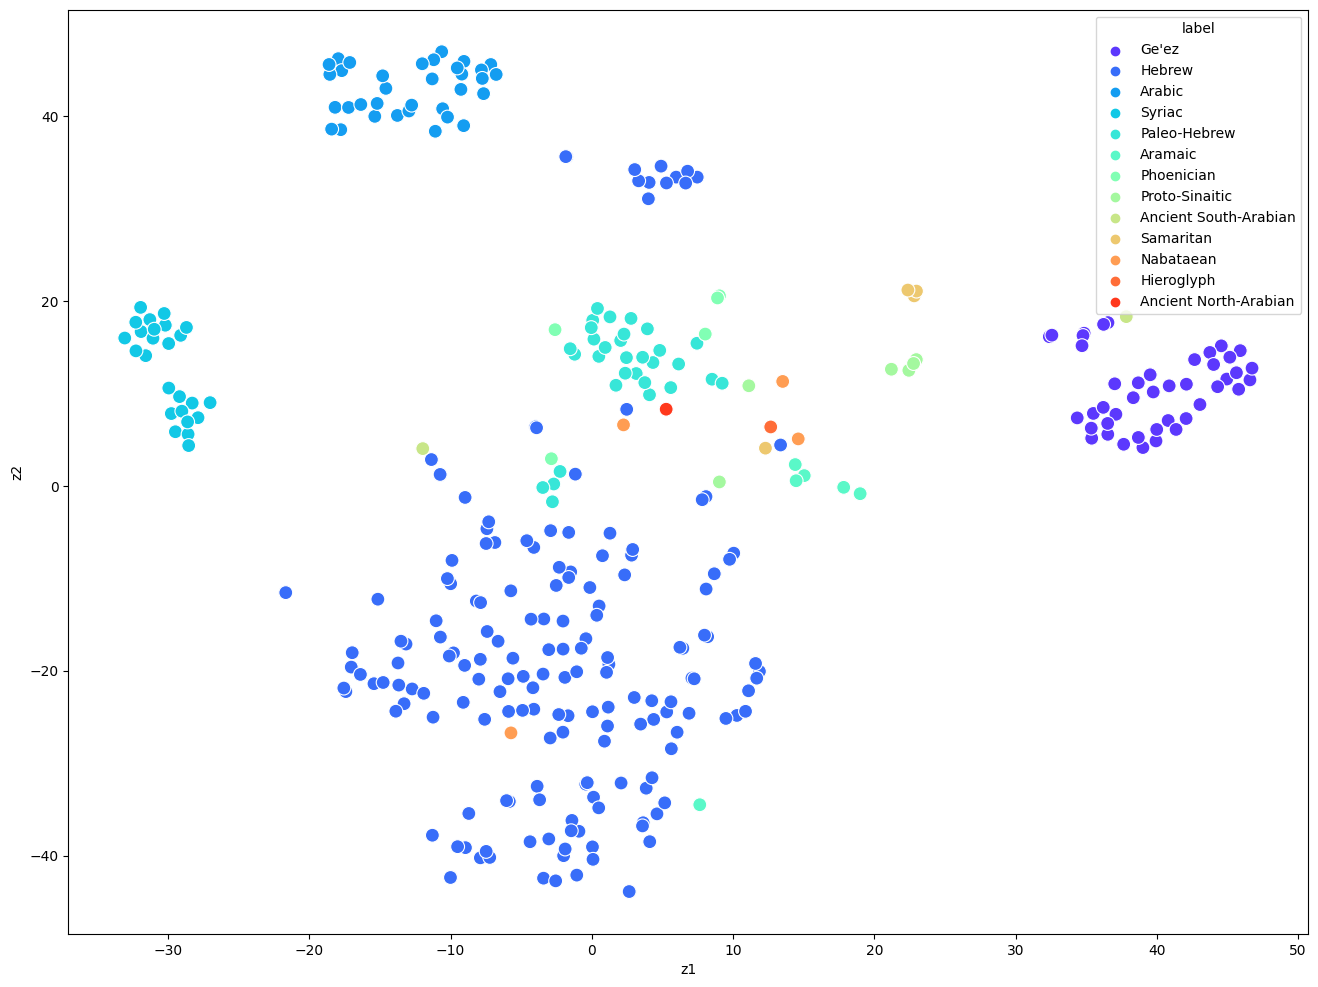

In [50]:
labels = [dataset.classes[i] for i in y]
data = pd.DataFrame({
    'z1': z[:, 0],
    'z2': z[:, 1],
    'label': labels
})
fig = plt.figure(figsize=(16, 12))
scatter = sns.scatterplot(x='z1', y='z2', hue='label', palette="rainbow", data=data, s=100)
plt.show() 


Plot original and reconstructed images according to their location in the latent space.

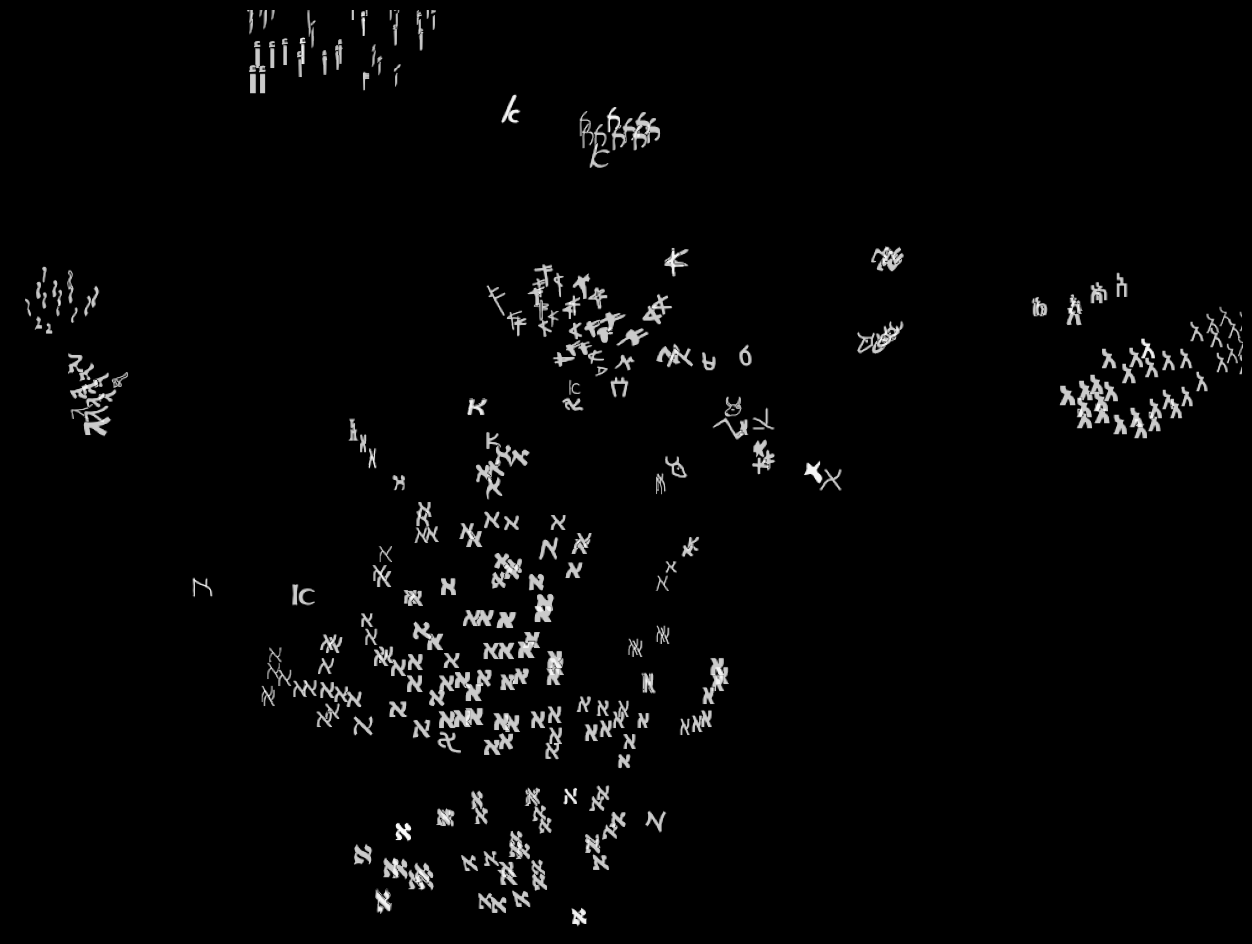

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_images_with_coordinates(images, coordinates, width=1000, height=750):
    normalized_x, normalized_y = coordinates[:, 0], coordinates[:, 1]
    normalized_x = (normalized_x - np.min(normalized_x)) / (np.max(normalized_x) - np.min(normalized_x))
    normalized_y = (normalized_y - np.min(normalized_y)) / (np.max(normalized_y) - np.min(normalized_y))

    plt.figure(figsize=(16, 12), facecolor='black')

    for grapheme, norm_x, norm_y in zip(images, normalized_x, normalized_y):
        grapheme_cv2 = cv2.cvtColor(np.array(grapheme), cv2.COLOR_RGBA2BGRA)

        gray = cv2.cvtColor(grapheme_cv2, cv2.COLOR_BGRA2GRAY)
        _, alpha = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)

        b, g, r, _ = cv2.split(grapheme_cv2)
        rgba = [b, g, r, alpha]
        grapheme_no_bg = cv2.merge(rgba, 4)

        x_coord = int(width * norm_x)
        y_coord = int(height * norm_y)

        plt.imshow(grapheme_no_bg, extent=[x_coord, x_coord + grapheme.width, y_coord, y_coord + grapheme.height], alpha=0.8)

    plt.xlim(0, width)
    plt.ylim(0, height)

    plt.axis('off')
    plt.grid(False)

    plt.show()

# Example usage
plot_images_with_coordinates(images, z)


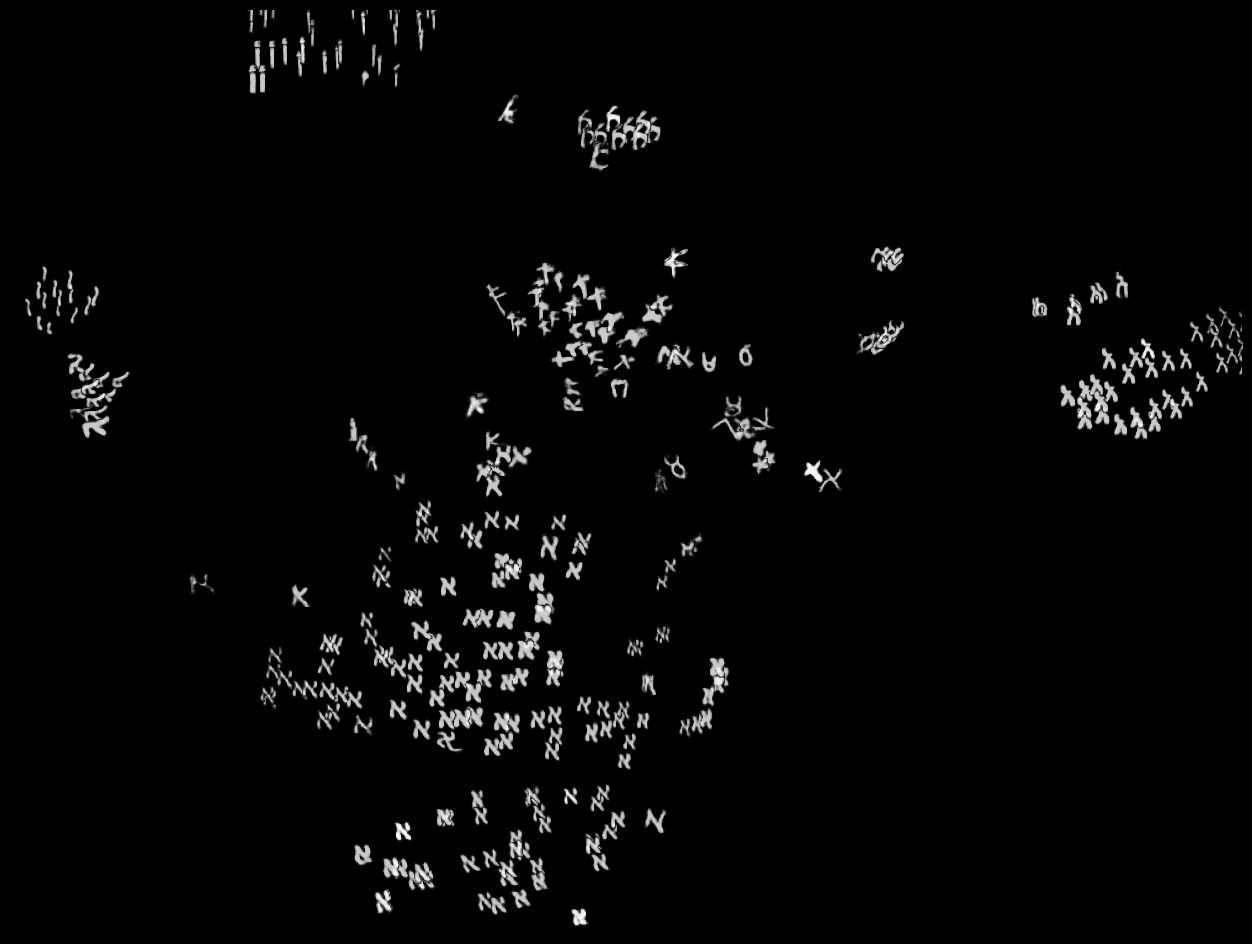

In [52]:
plot_images_with_coordinates(reconstructions, z)


plot the bounding area of the latent representations (only for 2d latent space)

# Latent Space Interpolation

In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def interpolation(lambda1, model, img1, img2, y):
    # y is 5 as tensor
    y = torch.tensor([y])

    with torch.no_grad():
        img1 = img1.to(device)
        latent_1, _ = model.capsnet(img1)
        recon = model.reconstruction_net(latent_1, y)

        img2 = img2.to(device)
        latent_2, _ = model.capsnet(img2)
        recon_2 = model.reconstruction_net(latent_2, y)

        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2
        inter_image = model.reconstruction_net(inter_latent, y)
        inter_image = inter_image.data.view(-1, 1, 28, 28).cpu()

        return inter_image

def plot_interpolation(models, n_steps, img1, img2, y):
    model_names = list(models.keys())
    n_models = len(model_names)
    lambda_range = np.linspace(0, 1, n_steps)

    fig, axs = plt.subplots(n_models, n_steps, figsize=(n_steps, n_models))

    for i, model_name in enumerate(model_names):
        axs[i][0].text(-0.5, 0.5, model_name, fontsize=12, ha='right', va='center')
        for j, l in enumerate(lambda_range):
            inter_image = interpolation(float(l), models[model_name], img1, img2, y)
            img_np = inter_image.numpy()
            img_np = img_np.squeeze() * 255
            pil_img = Image.fromarray(img_np.astype('uint8'), mode='L')
            axs[i][j].imshow(pil_img, cmap='gray')
            axs[i][j].axis('off')
            axs[i][j].grid(False)
    plt.show()


# Interpolate between letter variations

to evaluate the model's interpolation we choose image pairs that are different in:
* weight (thickness)
* size
* translation
* rotation
* slant (italic)
* style (font family)

In [90]:
heb_char = 'א'
ar_char = 'أ'
geez_char = 'አ'

ar_label = 2
geez_label = 4
heb_label = 5


/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)


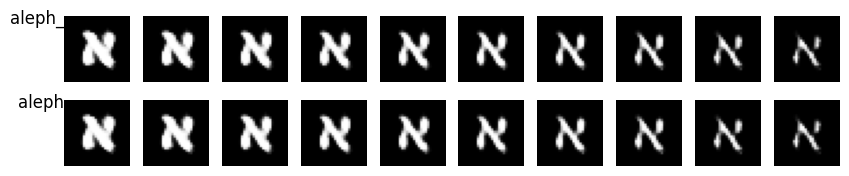

In [80]:
# Weight 
thin_path = f"datasets/base_dataset/{letter}/Hebrew/{letter}_Hebrew_NotoSansHebrew-Thin_{heb_char}_22_0.0.png"
thick_path = f"datasets/base_dataset/{letter}/Hebrew/{letter}_Hebrew_NotoSansHebrew-Black_{heb_char}_22_0.0.png"

# load images and convert to tensors, then call plot_interpolation
thin_img = Image.open(thin_path).convert('L')
thick_img = Image.open(thick_path).convert('L')
thin = transforms.ToTensor()(thin_img).unsqueeze(0)
thick = transforms.ToTensor()(thick_img).unsqueeze(0)
plot_interpolation({"aleph_":model, "aleph":model}, 10, thin, thick, heb_label)

/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)


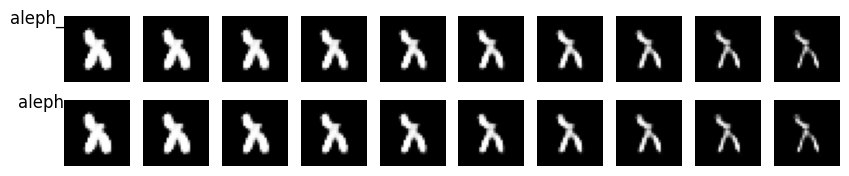

In [82]:
# Weight 
thin_path = f"datasets/base_dataset/{letter}/Ge'ez/{letter}_Ge'ez_NotoSansEthiopic-Thin_{geez_char}_22_0.0.png"
thick_path = f"datasets/base_dataset/{letter}/Ge'ez/{letter}_Ge'ez_NotoSansEthiopic-Black_{geez_char}_22_0.0.png"

# load images and convert to tensors, then call plot_interpolation
thin_img = Image.open(thin_path).convert('L')
thick_img = Image.open(thick_path).convert('L')
thin = transforms.ToTensor()(thin_img).unsqueeze(0)
thick = transforms.ToTensor()(thick_img).unsqueeze(0)
plot_interpolation({"aleph_":model, "aleph":model}, 10, thin, thick, geez_label)

/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)


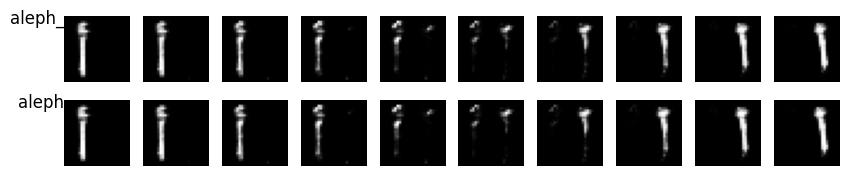

In [91]:
# Translation
left_path = f"datasets/moderate_dataset/{letter}/Arabic/aleph_Arabic_NotoKufiArabic-ExtraLight_أ_23_0.8197145669735337.png"
right_path = f"datasets/moderate_dataset/{letter}/Arabic/aleph_Arabic_NotoKufiArabic-Light_أ_22_-6.885105878513751.png"

# load images and convert to tensors, then call plot_interpolation
left_img = Image.open(left_path).convert('L')
right_img = Image.open(right_path).convert('L')
left = transforms.ToTensor()(left_img).unsqueeze(0)
right = transforms.ToTensor()(right_img).unsqueeze(0)
plot_interpolation({"aleph_":model, "aleph":model}, 10, right, left, ar_label)

/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)


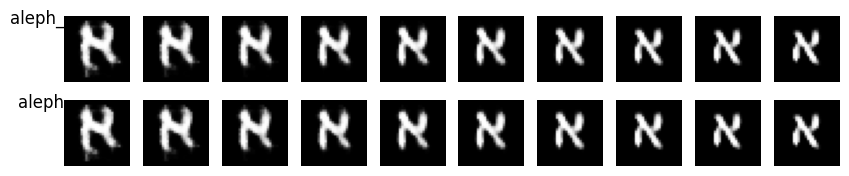

In [74]:
# Translation
small_path = f"datasets/moderate_dataset/{letter}/Hebrew/aleph_Hebrew_OS Aran_400FFC_א_25_2.715677593407859.png"
big_path = f"datasets/moderate_dataset/{letter}/Hebrew/aleph_Hebrew_miriwin-webfont_א_25_-5.702912909956729.png"

# load images and convert to tensors, then call plot_interpolation
small_img = Image.open(small_path).convert('L')
big_img = Image.open(big_path).convert('L')
small = transforms.ToTensor()(small_img).unsqueeze(0)
big = transforms.ToTensor()(big_img).unsqueeze(0)
plot_interpolation({"aleph_":model, "aleph":model}, 10, small, big)

/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)


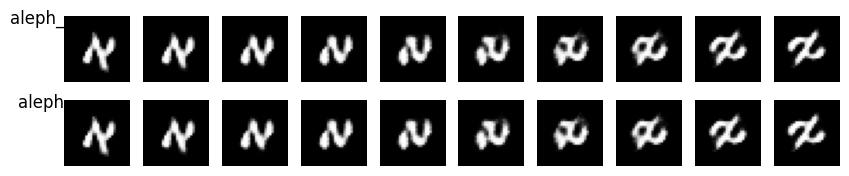

In [76]:
# Translation
small_path = f"datasets/rich_rotation_dataset/{letter}/Hebrew/aleph_Hebrew_MiriamLibre-Regular_א_23_68.03898904676012.png"
big_path = f"datasets/rich_rotation_dataset/{letter}/Hebrew/aleph_Hebrew_MiriamLibre-Regular_א_22_15.878657815471215.png"

# load images and convert to tensors, then call plot_interpolation
small_img = Image.open(small_path).convert('L')
big_img = Image.open(big_path).convert('L')
small = transforms.ToTensor()(small_img).unsqueeze(0)
big = transforms.ToTensor()(big_img).unsqueeze(0)
plot_interpolation({"aleph_":model, "aleph":model}, 10, small, big)

# Extrapolate between writing systems

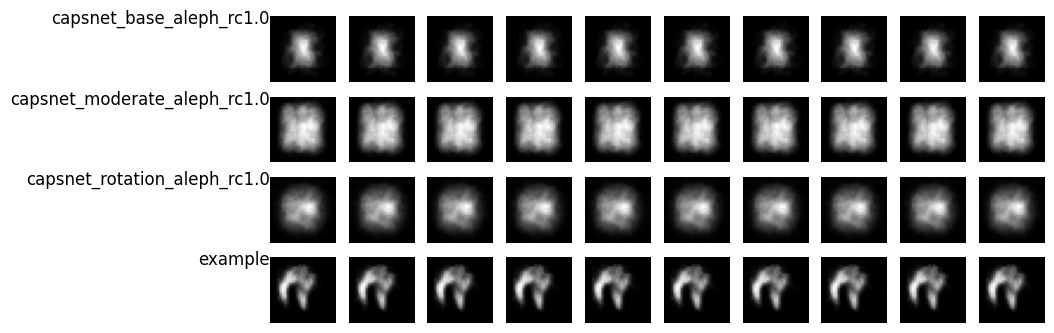

In [18]:
# sort part of test set by writing system
scripts = {script : [] for script in dataset.classes}
for img_batch, label_batch in dataloader:
    for i in range(img_batch.size(0)):
        scripts[dataset.classes[label_batch[i]]].append(img_batch[i:i+1])
    if sum(len(d) for d in scripts) >= 1000:
        break;

heb_img = scripts["Hebrew"][0]
ar_img = scripts["Arabic"][0]

# Example usage
n_steps = 10
plot_interpolation(models, n_steps, heb_img, ar_img)